# Análisis NLP de Tweets Políticos Colombianos
## Procesamiento de Lenguaje Natural para Ciencias Sociales

### Objetivos de la clase
En esta clase práctica analizaremos tweets de 4 políticos colombianos usando técnicas de NLP con spaCy:
- Gustavo Petro
- Iván Duque  
- Álvaro Uribe
- Gustavo Bolívar

**Técnicas que aplicaremos:**
- N-gramas y análisis morfológico
- Extracción de entidades nombradas
- Análisis de menciones y hashtags
- Redes semánticas y análisis temporal
- Análisis de contexto político

---

## 1. Configuración inicial

In [14]:
# Instalación de librerías necesarias
!pip install spacy wordcloud networkx -q
!python -m spacy download es_core_news_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 12.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from collections import Counter, defaultdict
from wordcloud import WordCloud
import networkx as nx
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Cargar modelo de spaCy
nlp = spacy.load('es_core_news_md')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

print("Configuración completada")
print(f"Modelo spaCy cargado: {nlp.meta['name']}")

Configuración completada
Modelo spaCy cargado: core_news_md


## 2. Carga de datos desde Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
file_path = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/99. Datos/tweets_muestra_estratificada.csv'  # Replace with the actual path
df = pd.read_csv(file_path)
print(df.head())

                         id       politico                       fecha_raw  \
0  677f1f14782ccacddc4e6e35  Gustavo Petro  Tue Mar 24 19:44:38 +0000 2020   
1  677f1f13782ccacddc4e6a20  Gustavo Petro  Thu Mar 26 13:29:14 +0000 2020   
2  677f1f15782ccacddc4e72c7  Gustavo Petro  Wed Mar 11 00:17:32 +0000 2020   
3  677f1f14782ccacddc4e6e26  Gustavo Petro  Tue Mar 24 21:19:29 +0000 2020   
4  677f1f13782ccacddc4e672d  Gustavo Petro  Fri Mar 27 12:25:47 +0000 2020   

                                               texto  \
0  Existe en nuestra sociedad burbujas informativ...   
1  La evaluación del presidente de la asociación ...   
2  Solo dejando de emitir CO2 en todo el mundo se...   
3  Solo he hablado una vez con el presidente para...   
4  El confinamiento se prolongará al menos dos me...   

                       fecha     año  mes  año_mes  
0  2020-03-24 19:44:38+00:00  2020.0  3.0  2020-03  
1  2020-03-26 13:29:14+00:00  2020.0  3.0  2020-03  
2  2020-03-11 00:17:32+00:00  2020.

## 3. Preprocesamiento y extracción de menciones/hashtags

In [18]:
def extract_mentions_hashtags(text):
    """
    Extrae menciones y hashtags de un tweet
    """
    if pd.isna(text):
        return False, "", []

    text = str(text)

    # Extraer menciones (@usuario)
    mentions = re.findall(r'@(\w+)', text)
    has_mention = len(mentions) > 0
    user_mentions = '@' + ', @'.join(mentions) if mentions else ""

    # Extraer hashtags (#hashtag)
    hashtags = re.findall(r'#(\w+)', text)

    return has_mention, user_mentions, hashtags

def clean_tweet_text(text):
    """
    Limpia el texto del tweet para análisis con spaCy
    """
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Eliminar URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Mantener menciones y hashtags para análisis posterior, pero limpiar para NLP
    text_for_nlp = re.sub(r'@\w+', '', text)  # Quitar menciones
    text_for_nlp = re.sub(r'#(\w+)', r'\1', text_for_nlp)  # Convertir #hashtag a hashtag

    # Limpiar caracteres especiales
    text_for_nlp = re.sub(r'[^\w\s]', ' ', text_for_nlp)
    text_for_nlp = re.sub(r'\s+', ' ', text_for_nlp).strip()

    return text_for_nlp


In [21]:
# Aplicar extracción de menciones y hashtags
print("Extrayendo menciones y hashtags...")
extraction_results = df['texto'].apply(extract_mentions_hashtags)

df['mention'] = [result[0] for result in extraction_results]
df['user_mention'] = [result[1] for result in extraction_results]
df['hashtags'] = [result[2] for result in extraction_results]

# Limpiar texto para análisis NLP
df['texto_limpio'] = df['texto'].apply(clean_tweet_text)

# Filtrar tweets con contenido suficiente
df = df[df['texto_limpio'].str.len() > 10].reset_index(drop=True)

print(f"Tweets después de limpieza: {len(df):,}")
print(f"Tweets con menciones: {df['mention'].sum():,} ({df['mention'].mean()*100:.1f}%)")
print(f"Total de hashtags únicos: {len(set([tag for tags in df['hashtags'] for tag in tags]))}")

Extrayendo menciones y hashtags...
Tweets después de limpieza: 3,988
Tweets con menciones: 849 (21.3%)
Total de hashtags únicos: 782



## 4. Procesamiento con spaCy

In [22]:
def process_with_spacy(text):
    """
    Procesa texto con spaCy y extrae información lingüística
    """
    if not text or len(text.strip()) < 3:
        return {
            'tokens': [],
            'lemmas': [],
            'pos_tags': [],
            'entities': []
        }

    doc = nlp(text)

    # Extraer tokens útiles (filtrar stopwords, puntuación, etc.)
    tokens = []
    lemmas = []
    pos_tags = []

    for token in doc:
        if (not token.is_stop and
            not token.is_punct and
            not token.is_space and
            token.is_alpha and
            len(token.text) > 2):

            tokens.append(token.text.lower())
            lemmas.append(token.lemma_.lower())
            pos_tags.append((token.text.lower(), token.pos_, token.tag_))

    # Extraer entidades nombradas
    entities = [(ent.text.lower(), ent.label_) for ent in doc.ents if len(ent.text) > 2]

    return {
        'tokens': tokens,
        'lemmas': lemmas,
        'pos_tags': pos_tags,
        'entities': entities
    }

In [23]:
# Procesar tweets con spaCy (puede tardar unos minutos)
print("Procesando tweets con spaCy...")

spacy_results = []
batch_size = 100

for i in range(0, len(df), batch_size):
    batch = df['texto_limpio'].iloc[i:i+batch_size]
    batch_results = [process_with_spacy(text) for text in batch]
    spacy_results.extend(batch_results)

    if (i // batch_size + 1) % 10 == 0:
        print(f"Procesados: {i+batch_size:,}/{len(df):,} tweets")

# Agregar resultados al dataframe
df['tokens'] = [result['tokens'] for result in spacy_results]
df['lemmas'] = [result['lemmas'] for result in spacy_results]
df['pos_tags'] = [result['pos_tags'] for result in spacy_results]
df['entities'] = [result['entities'] for result in spacy_results]

# Filtrar tweets con contenido insuficiente después del procesamiento
df = df[df['tokens'].str.len() >= 3].reset_index(drop=True)

print(f"Procesamiento completado: {len(df):,} tweets listos para análisis")

# Agregar información temporal por trimestres
df['fecha'] = pd.to_datetime(df['fecha'])
df['año'] = df['fecha'].dt.year
df['trimestre'] = df['fecha'].dt.quarter
df['año_trimestre'] = df['año'].astype(str) + '-Q' + df['trimestre'].astype(str)

print(f"Período de análisis: {df['fecha'].min()} - {df['fecha'].max()}")

Procesando tweets con spaCy...
Procesados: 1,000/3,988 tweets
Procesados: 2,000/3,988 tweets
Procesados: 3,000/3,988 tweets
Procesados: 4,000/3,988 tweets
Procesamiento completado: 3,878 tweets listos para análisis
Período de análisis: 2019-01-01 01:30:52+00:00 - 2024-08-27 14:04:20+00:00



## 5. Análisis exploratorio - Nubes de palabras

In [24]:
def create_wordcloud_by_politician(df, politician):
    """
    Crea nube de palabras para un político específico
    """
    politician_tweets = df[df['politico'] == politician]

    # Combinar todos los lemmas del político
    all_lemmas = []
    for lemmas in politician_tweets['lemmas']:
        all_lemmas.extend(lemmas)

    if not all_lemmas:
        print(f"No hay suficientes datos para {politician}")
        return

    # Crear texto para la nube
    text = ' '.join(all_lemmas)

    # Generar nube de palabras
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=50,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras - {politician}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Mostrar palabras más frecuentes
    word_freq = Counter(all_lemmas).most_common(15)
    print(f"\nPalabras más frecuentes - {politician}:")
    for i, (word, freq) in enumerate(word_freq, 1):
        print(f"  {i:2d}. {word:<15} ({freq:3d})")

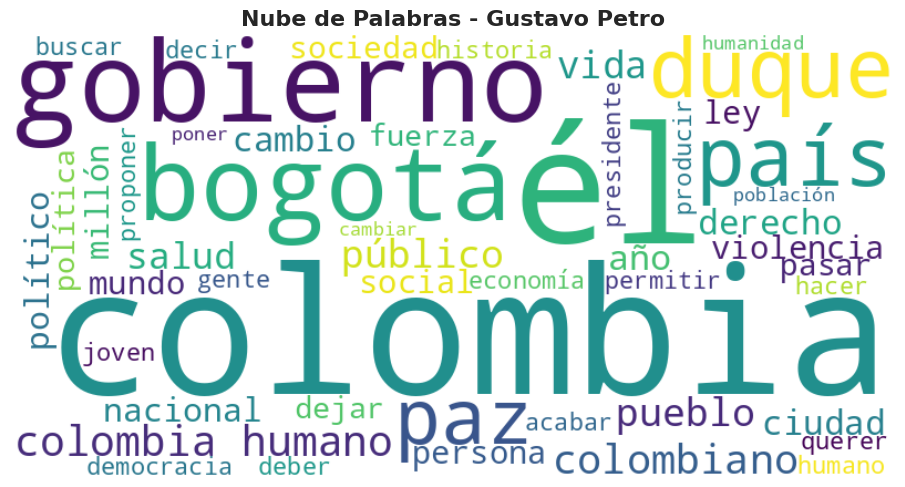


Palabras más frecuentes - Gustavo Petro:
   1. colombia        (313)
   2. bogotá          (158)
   3. gobierno        (155)
   4. humano          (143)
   5. público         (109)
   6. duque           (107)
   7. país            (106)
   8. paz             (102)
   9. social          (101)
  10. colombiano      ( 97)
  11. salud           ( 93)
  12. cambio          ( 88)
  13. pueblo          ( 83)
  14. vida            ( 79)
  15. sociedad        ( 70)




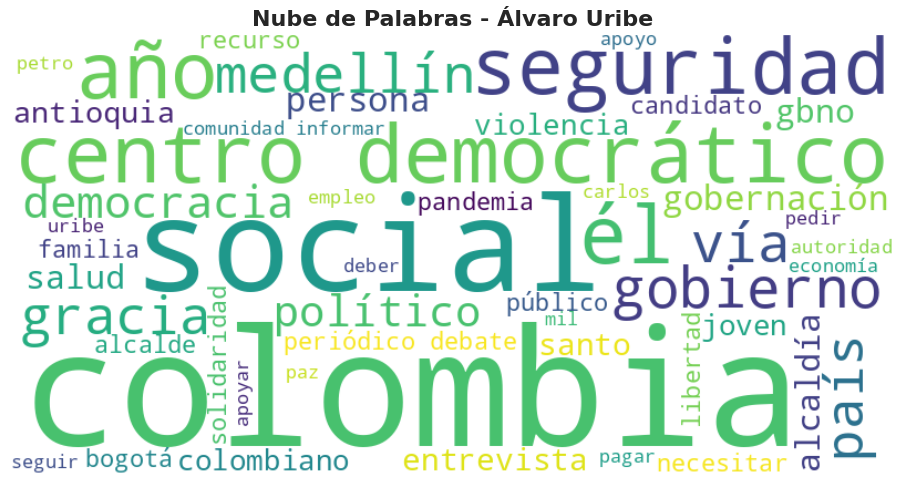


Palabras más frecuentes - Álvaro Uribe:
   1. colombia        ( 77)
   2. democrático     ( 55)
   3. familia         ( 52)
   4. usd             ( 52)
   5. social          ( 50)
   6. solidaridad     ( 50)
   7. centro          ( 47)
   8. onza            ( 47)
   9. año             ( 40)
  10. país            ( 39)
  11. seguridad       ( 39)
  12. gobierno        ( 38)
  13. alcaldía        ( 38)
  14. vía             ( 36)
  15. comunidad       ( 36)




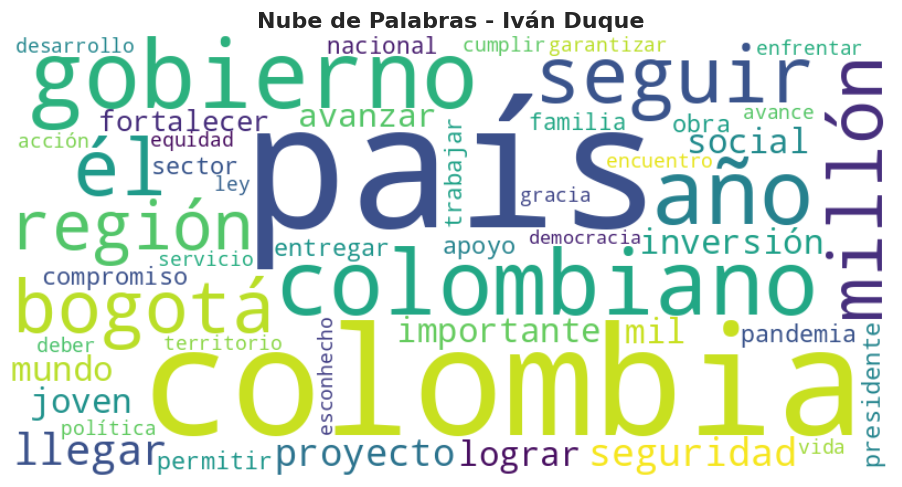


Palabras más frecuentes - Iván Duque:
   1. país            (231)
   2. colombia        (170)
   3. gobierno        (107)
   4. colombiano      ( 93)
   5. año             ( 84)
   6. millón          ( 79)
   7. seguir          ( 73)
   8. mil             ( 65)
   9. inversión       ( 57)
  10. trabajo         ( 54)
  11. bogotá          ( 54)
  12. región          ( 52)
  13. llegar          ( 52)
  14. seguridad       ( 52)
  15. social          ( 51)




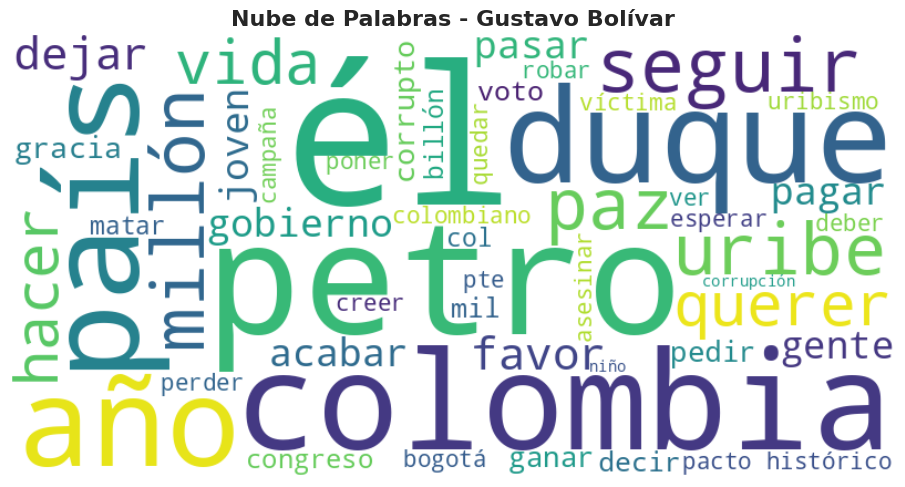


Palabras más frecuentes - Gustavo Bolívar:
   1. petro           (103)
   2. colombia        ( 97)
   3. duque           ( 82)
   4. país            ( 79)
   5. millón          ( 73)
   6. año             ( 72)
   7. seguir          ( 59)
   8. paz             ( 58)
   9. uribe           ( 55)
  10. favor           ( 53)
  11. vida            ( 50)
  12. social          ( 48)
  13. mil             ( 48)
  14. querer          ( 47)
  15. gobierno        ( 46)




In [25]:
# Crear nubes de palabras para cada político
for politician in df['politico'].unique():
    create_wordcloud_by_politician(df, politician)
    print("\n" + "="*60 + "\n")

### Ejercicio:
**Observa las nubes de palabras y identifica 5-8 palabras clave que consideres importantes para el análisis de contexto político. Escribe tu lista aquí:**


In [26]:
# TU TURNO: Define las palabras clave basándote en las nubes de palabras
palabras_clave_estudiantes = [
    # Ejemplo: 'colombia', 'gobierno', 'pueblo'
    # Completa con las palabras que identificaste:

]

print("Palabras clave seleccionadas:", palabras_clave_estudiantes)

Palabras clave seleccionadas: []


## 6. Análisis de N-gramas

In [27]:
def analyze_ngrams(df, politician, n=2, top_k=15):
    """
    Analiza n-gramas para un político específico
    """
    politician_data = df[df['politico'] == politician]

    # Usar lemmas para mejor agrupación
    all_ngrams = []

    for lemmas in politician_data['lemmas']:
        if len(lemmas) >= n:
            for i in range(len(lemmas) - n + 1):
                ngram = tuple(lemmas[i:i+n])
                all_ngrams.append(ngram)

    # Contar frecuencias
    ngram_counts = Counter(all_ngrams).most_common(top_k)

    return ngram_counts

def visualize_ngrams(df, ngram_type='bigrams', top_k=10):
    """
    Visualiza n-gramas para todos los políticos
    """
    n = 2 if ngram_type == 'bigrams' else 3

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    politicians = df['politico'].unique()

    for i, politician in enumerate(politicians):
        ngrams = analyze_ngrams(df, politician, n=n, top_k=top_k)

        if ngrams and i < len(axes):
            # Preparar datos para visualización
            labels = [' '.join(ngram) for ngram, _ in ngrams]
            frequencies = [freq for _, freq in ngrams]

            # Crear gráfico
            bars = axes[i].barh(range(len(labels)), frequencies)
            axes[i].set_yticks(range(len(labels)))
            axes[i].set_yticklabels(labels)
            axes[i].set_xlabel('Frecuencia')
            axes[i].set_title(f'{politician} - Top {ngram_type.capitalize()}')
            axes[i].invert_yaxis()

            # Añadir valores en barras
            for j, (bar, freq) in enumerate(zip(bars, frequencies)):
                axes[i].text(freq + 0.1, j, str(freq), va='center')

    plt.suptitle(f'Análisis de {ngram_type.capitalize()} por Político', fontsize=16)
    plt.tight_layout()
    plt.show()

Análisis de Bigramas (pares de palabras):


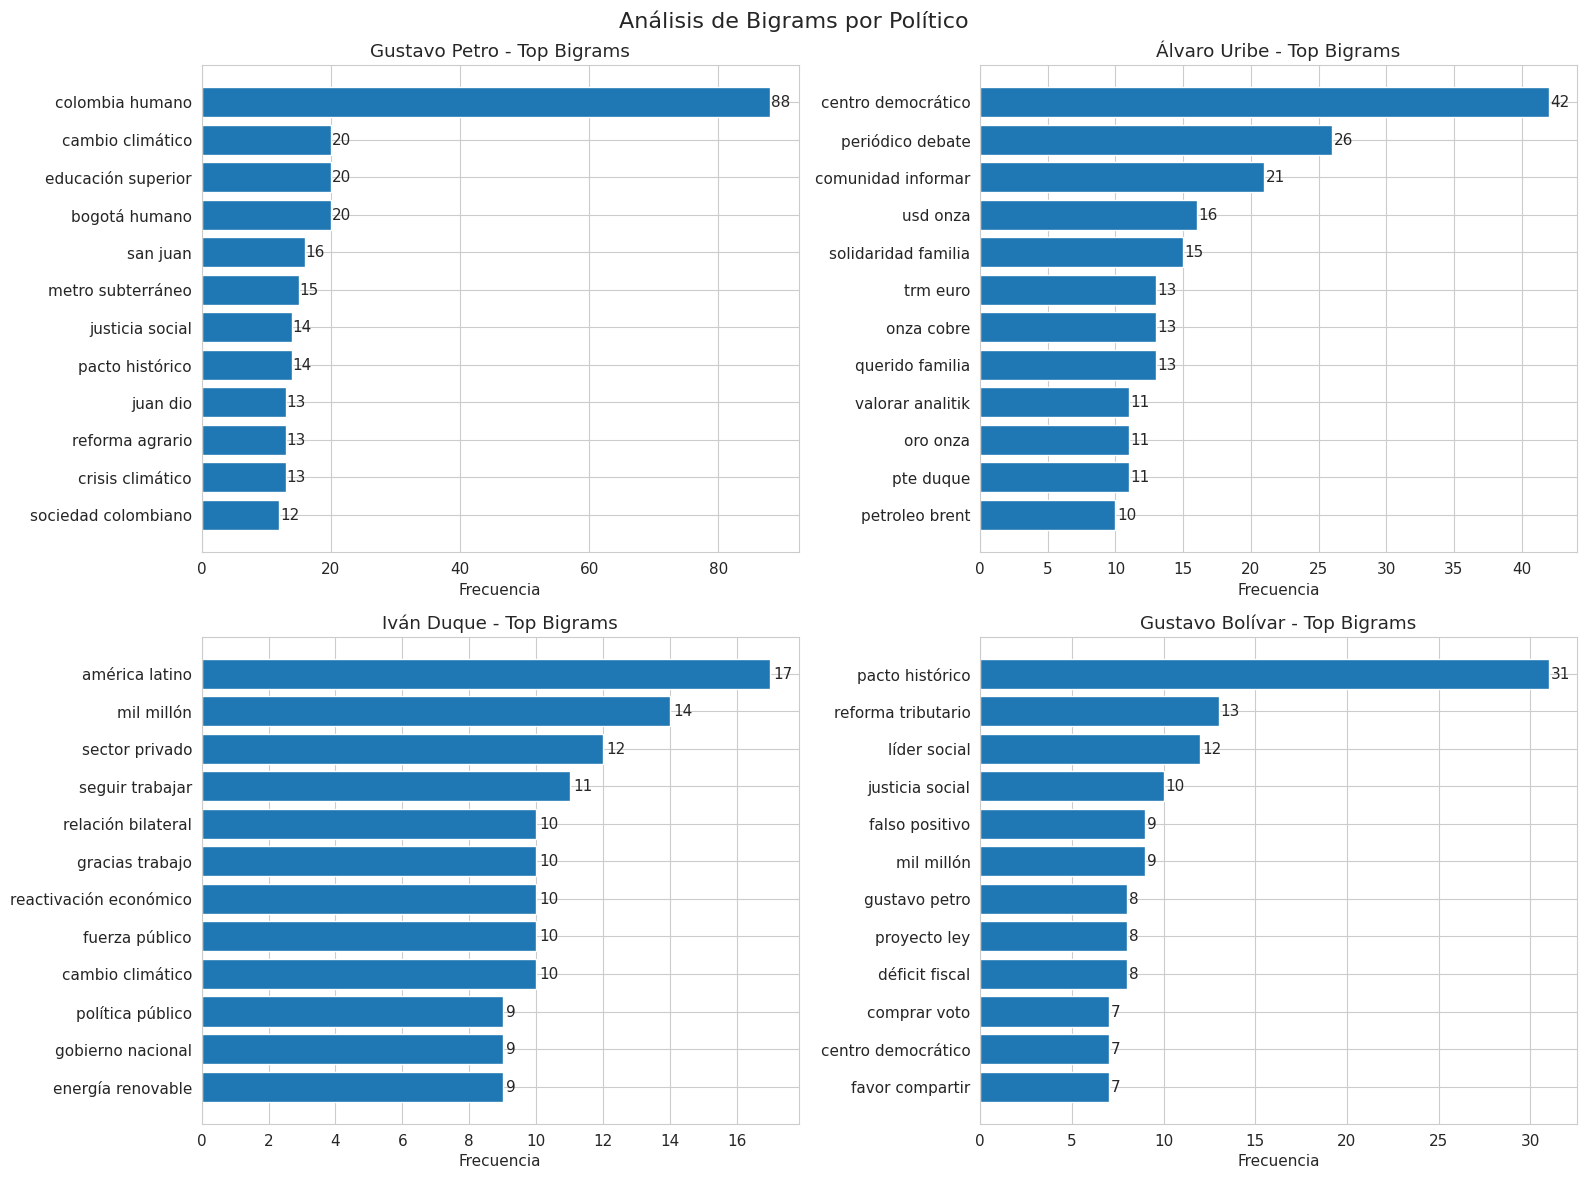

In [28]:
# Análisis de bigramas
print("Análisis de Bigramas (pares de palabras):")
visualize_ngrams(df, 'bigrams', top_k=12)

### Ejercicio:
**Completa el análisis de trigramas:**

In [29]:
# TU TURNO: Completa el análisis de trigramas
print("Análisis de Trigramas (grupos de tres palabras):")

# Escribe aquí el código para analizar trigramas
# Pista: usa la función visualize_ngrams con el parámetro correcto

Análisis de Trigramas (grupos de tres palabras):


## 7. Análisis morfológico con spaCy

### Guía para interpretar POS Tags (Part-of-Speech)

**Categorías principales en spaCy (español):**
- **NOUN** (Sustantivo): personas, lugares, cosas, conceptos
- **VERB** (Verbo): acciones, estados, procesos  
- **ADJ** (Adjetivo): cualidades, características
- **ADV** (Adverbio): modifica verbos, adjetivos u otros adverbios
- **PRON** (Pronombre): sustituye a nombres (yo, tú, él, nosotros)
- **DET** (Determinante): artículos y determinantes (el, la, un, esta)
- **ADP** (Adposición): preposiciones (en, de, con, para)
- **CCONJ** (Conjunción coordinante): y, o, pero
- **NUM** (Número): números cardinales y ordinales

**¿Qué nos dice el análisis POS?**
- **Alto % de NOUN**: Discurso centrado en conceptos, temas específicos
- **Alto % de VERB**: Discurso orientado a la acción
- **Alto % de ADJ**: Discurso descriptivo, evaluativo
- **Ratio NOUN/VERB**: Equilibrio entre conceptos y acciones

In [30]:
def analyze_pos_by_politician(df):
    """
    Analiza distribución de categorías morfológicas por político
    """
    results = {}

    for politician in df['politico'].unique():
        politician_data = df[df['politico'] == politician]

        # Recopilar todos los POS tags
        all_pos = []
        nouns = []
        verbs = []
        adjectives = []

        for pos_tags in politician_data['pos_tags']:
            for word, pos, tag in pos_tags:
                all_pos.append(pos)

                if pos == 'NOUN':
                    nouns.append(word)
                elif pos == 'VERB':
                    verbs.append(word)
                elif pos == 'ADJ':
                    adjectives.append(word)

        # Calcular estadísticas
        pos_counts = Counter(all_pos)
        total_words = sum(pos_counts.values())

        if total_words > 0:
            results[politician] = {
                'total_words': total_words,
                'pos_distribution': dict(pos_counts),
                'pos_percentages': {pos: (count/total_words)*100 for pos, count in pos_counts.items()},
                'top_nouns': Counter(nouns).most_common(10),
                'top_verbs': Counter(verbs).most_common(10),
                'top_adjectives': Counter(adjectives).most_common(10),
                'noun_verb_ratio': len(nouns) / max(len(verbs), 1)
            }

    return results

def visualize_pos_analysis(pos_results):
    """
    Visualiza análisis morfológico
    """
    # 1. Distribución de POS tags
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    main_pos = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'DET']
    politicians = list(pos_results.keys())

    for i, politician in enumerate(politicians):
        if i < len(axes):
            data = pos_results[politician]['pos_percentages']
            pos_data = {pos: data.get(pos, 0) for pos in main_pos}

            bars = axes[i].bar(pos_data.keys(), pos_data.values())
            axes[i].set_title(f'{politician}\n({pos_results[politician]["total_words"]:,} palabras)')
            axes[i].set_ylabel('Porcentaje (%)')
            axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Distribución de Categorías Morfológicas', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 2. Comparación de ratios sustantivo/verbo
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    politicians = list(pos_results.keys())
    ratios = [pos_results[pol]['noun_verb_ratio'] for pol in politicians]

    bars = ax.bar(politicians, ratios)
    ax.set_title('Ratio Sustantivos/Verbos por Político')
    ax.set_ylabel('Ratio (Sustantivos/Verbos)')
    ax.tick_params(axis='x', rotation=45)

    # Añadir valores en barras
    for bar, ratio in zip(bars, ratios):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{ratio:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Análisis Morfológico con spaCy:


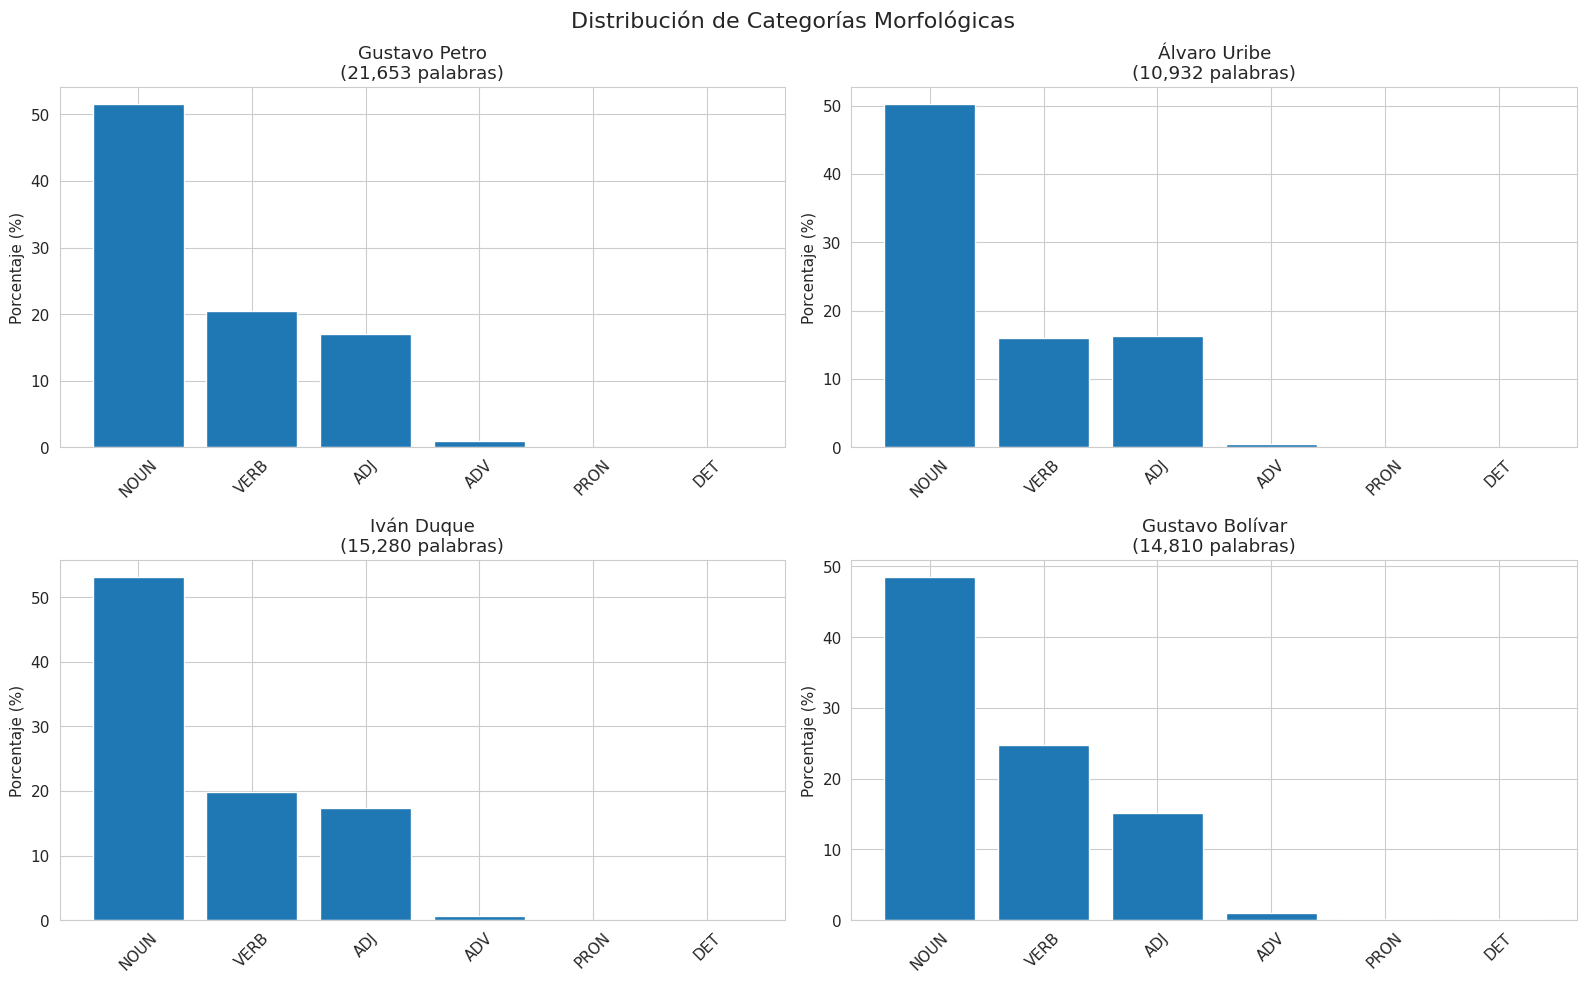

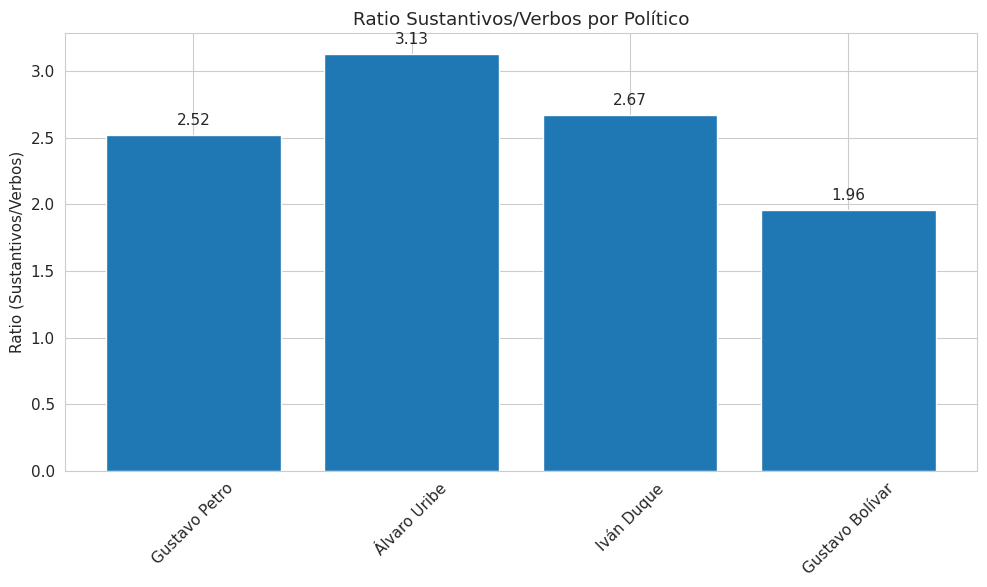


Gustavo Petro:
  Sustantivos más frecuentes: ['paz', 'gobierno', 'salud', 'país', 'duque']
  Verbos más frecuentes: ['cambiar', 'implica', 'quieren', 'construir', 'salir']
  Adjetivos más frecuentes: ['humana', 'social', 'nacional', 'pública', 'colombiana']

Álvaro Uribe:
  Sustantivos más frecuentes: ['solidaridad', 'usd', 'onza', 'centro', 'familia']
  Verbos más frecuentes: ['informa', 'necesita', 'siga', 'falleció', 'valora']
  Adjetivos más frecuentes: ['democrático', 'social', 'periódico', 'política', 'sociales']

Iván Duque:
  Sustantivos más frecuentes: ['país', 'gobierno', 'millones', 'colombianos', 'años']
  Verbos más frecuentes: ['seguimos', 'fortalecer', 'enfrentar', 'seguir', 'garantizar']
  Adjetivos más frecuentes: ['nacional', 'importante', 'social', 'pública', 'esconhechos']

Gustavo Bolívar:
  Sustantivos más frecuentes: ['petro', 'millones', 'país', 'duque', 'paz']
  Verbos más frecuentes: ['quieren', 'seguir', 'acabar', 'pasa', 'leer']
  Adjetivos más frecuentes: 

In [32]:
# Realizar análisis morfológico
print("Análisis Morfológico con spaCy:")
pos_analysis = analyze_pos_by_politician(df)
visualize_pos_analysis(pos_analysis)

# Mostrar palabras más frecuentes por categoría
for politician in pos_analysis.keys():
    print(f"\n{politician}:")
    print(f"  Sustantivos más frecuentes: {[word for word, _ in pos_analysis[politician]['top_nouns'][:5]]}")
    print(f"  Verbos más frecuentes: {[word for word, _ in pos_analysis[politician]['top_verbs'][:5]]}")
    print(f"  Adjetivos más frecuentes: {[word for word, _ in pos_analysis[politician]['top_adjectives'][:5]]}")

## 8. Análisis de entidades nombradas y menciones

In [33]:
def analyze_entities_and_mentions(df):
    """
    Analiza entidades nombradas y patrones de menciones
    """
    results = {}

    for politician in df['politico'].unique():
        politician_data = df[df['politico'] == politician]

        # Análisis de entidades
        all_entities = []
        entities_by_type = defaultdict(list)

        for entities in politician_data['entities']:
            for entity, ent_type in entities:
                all_entities.append((entity, ent_type))
                entities_by_type[ent_type].append(entity)

        # Análisis de menciones
        mentions_data = politician_data[politician_data['mention'] == True]
        all_mentions = []

        for mentions_str in mentions_data['user_mention']:
            if mentions_str:
                # Separar múltiples menciones
                mentions = [m.strip() for m in mentions_str.split(',')]
                all_mentions.extend(mentions)

        results[politician] = {
            'total_entities': len(all_entities),
            'entities_by_type': {ent_type: Counter(entities).most_common(10)
                               for ent_type, entities in entities_by_type.items()},
            'mention_frequency': len(mentions_data),
            'mention_rate': len(mentions_data) / len(politician_data) * 100,
            'top_mentioned_users': Counter(all_mentions).most_common(10)
        }

    return results

def visualize_mention_patterns(df, entities_mentions_results):
    """
    Visualiza patrones de menciones
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    politicians = df['politico'].unique()

    for i, politician in enumerate(politicians):
        if i < len(axes):
            data = entities_mentions_results[politician]
            top_mentions = data['top_mentioned_users'][:10]

            if top_mentions:
                users = [mention for mention, _ in top_mentions]
                counts = [count for _, count in top_mentions]

                bars = axes[i].barh(range(len(users)), counts)
                axes[i].set_yticks(range(len(users)))
                axes[i].set_yticklabels(users)
                axes[i].set_xlabel('Frecuencia de Mención')
                axes[i].set_title(f'{politician}\n({data["mention_rate"]:.1f}% tweets con menciones)')
                axes[i].invert_yaxis()

                # Añadir valores
                for j, (bar, count) in enumerate(zip(bars, counts)):
                    axes[i].text(count + 0.1, j, str(count), va='center')
            else:
                axes[i].text(0.5, 0.5, 'Sin menciones\nsuficientes',
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{politician}')

    plt.suptitle('Usuarios Más Mencionados por Político', fontsize=16)
    plt.tight_layout()
    plt.show()

In [35]:
# Realizar análisis
print("Análisis de Entidades Nombradas y Menciones:")
entities_mentions = analyze_entities_and_mentions(df)

# Mostrar estadísticas de menciones
print("\nEstadísticas de Menciones:")
for politician in entities_mentions.keys():
    data = entities_mentions[politician]
    print(f"{politician}:")
    print(f"  - Tweets con menciones: {data['mention_frequency']} ({data['mention_rate']:.1f}%)")
    print(f"  - Entidades identificadas: {data['total_entities']}")

Análisis de Entidades Nombradas y Menciones:

Estadísticas de Menciones:
Gustavo Petro:
  - Tweets con menciones: 72 (5.5%)
  - Entidades identificadas: 1495
Álvaro Uribe:
  - Tweets con menciones: 97 (10.9%)
  - Entidades identificadas: 1006
Iván Duque:
  - Tweets con menciones: 356 (44.4%)
  - Entidades identificadas: 897
Gustavo Bolívar:
  - Tweets con menciones: 282 (32.8%)
  - Entidades identificadas: 932


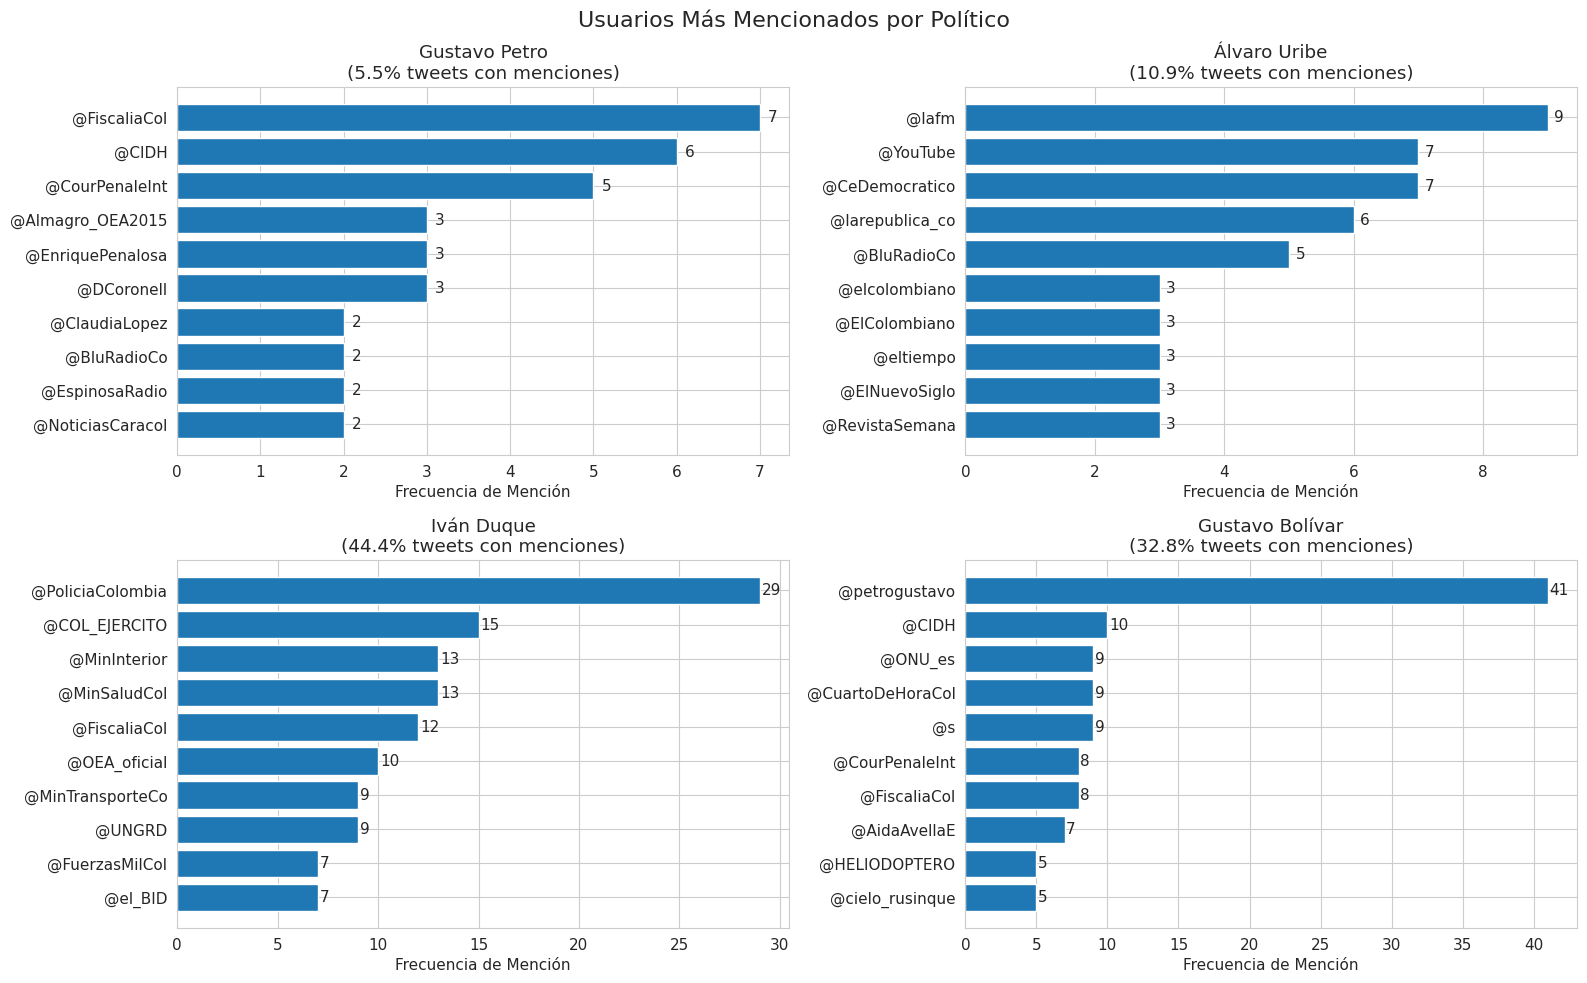


Entidades más mencionadas por tipo:

Gustavo Petro:
  LOC: colombia, bogotá, de colombia, la colombia, eeuu
  PER: uribe, claudia, fajardo, san juan de dios, trump
  ORG: odebrecht, farc, naciones unidas, oea, ocde
  MISC: eln, facebook live, paz de colombia, internet, masacre de bogotá

Álvaro Uribe:
  LOC: colombia, medellín, bogotá, antioquia, de colombia
  PER: uribe, maduro, rafael, chávez, álvaro uribe vélez
  ORG: farc, comunidad, santos, jep, odebrecht
  MISC: eln, comunidad, café, us 5, epm

Iván Duque:
  PER: enequipo, covid19, maduro, hamás, hidroituango
  MISC: eln, covid_19, quiero, risaralda, presidente de chile
  LOC: colombia, bogotá, de colombia, venezuela, medellín
  ORG: onu, cne, farc, consejo de seguridad, sec gral

Gustavo Bolívar:
  PER: uribe, hollman, maduro, fajardo, claudia
  LOC: colombia, bogotá, de colombia, eeuu, medellín
  MISC: losgustavos, ahora, gob duque, matrix, b v i
  ORG: farc, btá, jep, cne, partido verde


In [36]:
# Visualizar patrones de menciones
visualize_mention_patterns(df, entities_mentions)

# Mostrar entidades por tipo
print("\nEntidades más mencionadas por tipo:")
for politician in entities_mentions.keys():
    print(f"\n{politician}:")
    for ent_type, entities in entities_mentions[politician]['entities_by_type'].items():
        if entities:
            top_entities = [ent for ent, _ in entities[:5]]
            print(f"  {ent_type}: {', '.join(top_entities)}")

## 9. Análisis de hashtags

In [37]:
def analyze_hashtags(df):
    """
    Analiza uso de hashtags por político
    """
    results = {}

    for politician in df['politico'].unique():
        politician_data = df[df['politico'] == politician]

        # Recopilar todos los hashtags
        all_hashtags = []
        tweets_with_hashtags = 0

        for hashtags_list in politician_data['hashtags']:
            if hashtags_list:
                all_hashtags.extend(hashtags_list)
                tweets_with_hashtags += 1

        # Análisis de frecuencia
        hashtag_counts = Counter(all_hashtags)

        results[politician] = {
            'total_hashtags': len(all_hashtags),
            'unique_hashtags': len(set(all_hashtags)),
            'tweets_with_hashtags': tweets_with_hashtags,
            'hashtag_rate': tweets_with_hashtags / len(politician_data) * 100,
            'top_hashtags': hashtag_counts.most_common(15),
            'hashtag_diversity': len(set(all_hashtags)) / max(len(all_hashtags), 1)
        }

    return results

def visualize_hashtag_analysis(hashtag_results):
    """
    Visualiza análisis de hashtags
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    politicians = list(hashtag_results.keys())

    for i, politician in enumerate(politicians):
        if i < len(axes):
            data = hashtag_results[politician]
            top_hashtags = data['top_hashtags'][:12]

            if top_hashtags:
                hashtags = [f"#{tag}" for tag, _ in top_hashtags]
                counts = [count for _, count in top_hashtags]

                bars = axes[i].barh(range(len(hashtags)), counts)
                axes[i].set_yticks(range(len(hashtags)))
                axes[i].set_yticklabels(hashtags)
                axes[i].set_xlabel('Frecuencia de Uso')
                axes[i].set_title(f'{politician}\n({data["hashtag_rate"]:.1f}% tweets con hashtags)')
                axes[i].invert_yaxis()

                # Añadir valores
                for j, (bar, count) in enumerate(zip(bars, counts)):
                    axes[i].text(count + 0.1, j, str(count), va='center')
            else:
                axes[i].text(0.5, 0.5, 'Sin hashtags\nsuficientes',
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{politician}')

    plt.suptitle('Hashtags Más Utilizados por Político', fontsize=16)
    plt.tight_layout()
    plt.show()

In [39]:
# Realizar análisis de hashtags
print("Análisis de Hashtags:")
hashtag_analysis = analyze_hashtags(df)

# Mostrar estadísticas generales
print("\nEstadísticas de Hashtags:")
for politician in hashtag_analysis.keys():
    data = hashtag_analysis[politician]
    print(f"{politician}:")
    print(f"  - Tweets con hashtags: {data['tweets_with_hashtags']} ({data['hashtag_rate']:.1f}%)")
    print(f"  - Total hashtags usados: {data['total_hashtags']}")
    print(f"  - Hashtags únicos: {data['unique_hashtags']}")
    print(f"  - Diversidad: {data['hashtag_diversity']:.3f}")

Análisis de Hashtags:

Estadísticas de Hashtags:
Gustavo Petro:
  - Tweets con hashtags: 17 (1.3%)
  - Total hashtags usados: 19
  - Hashtags únicos: 16
  - Diversidad: 0.842
Álvaro Uribe:
  - Tweets con hashtags: 19 (2.1%)
  - Total hashtags usados: 21
  - Hashtags únicos: 17
  - Diversidad: 0.810
Iván Duque:
  - Tweets con hashtags: 493 (61.5%)
  - Total hashtags usados: 736
  - Hashtags únicos: 391
  - Diversidad: 0.531
Gustavo Bolívar:
  - Tweets con hashtags: 303 (35.2%)
  - Total hashtags usados: 399
  - Hashtags únicos: 361
  - Diversidad: 0.905


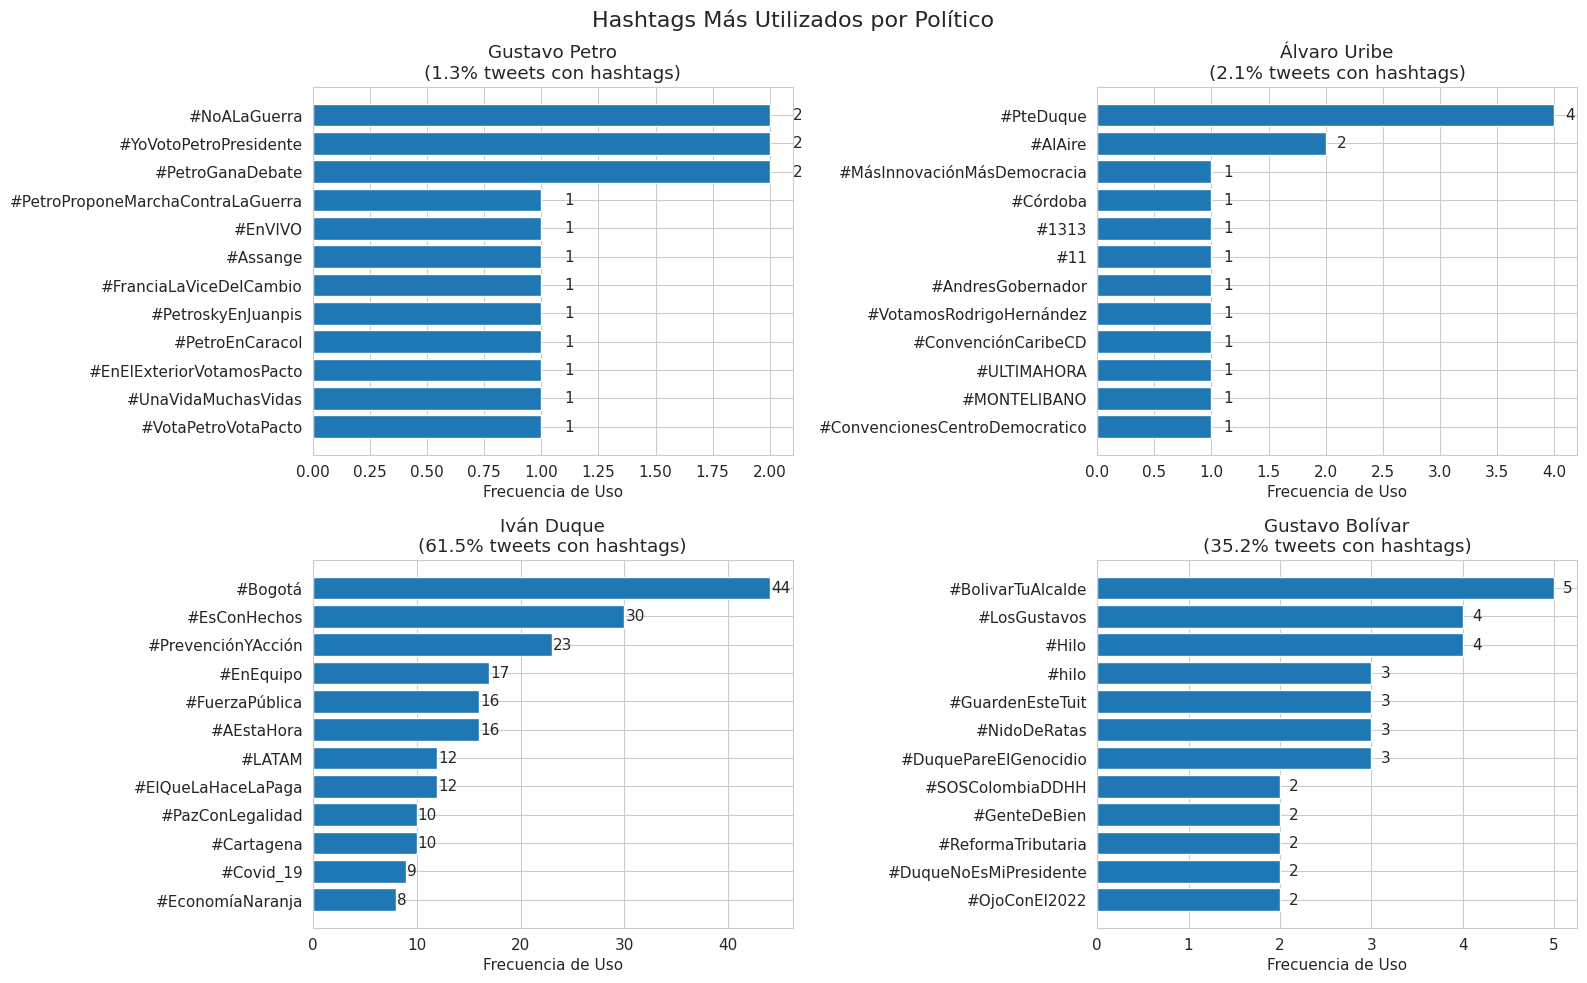

In [40]:
# Visualizar hashtags
visualize_hashtag_analysis(hashtag_analysis)


## 10. Análisis de contexto político

In [41]:
# Definir palabras clave (combinar palabras de nubes + palabras contextuales)
palabras_contexto_base = [
    'colombia', 'gobierno', 'estado', 'pueblo', 'paz', 'seguridad',
    'corrupción', 'democracia', 'economía', 'desarrollo', 'educación'
]

# Combinar con palabras identificadas por estudiantes y hashtags relevantes
def get_top_hashtags_for_context(hashtag_analysis, top_n=10):
    """Obtiene hashtags más relevantes para análisis de contexto"""
    all_hashtags = Counter()

    for politician_data in hashtag_analysis.values():
        for hashtag, count in politician_data['top_hashtags']:
            all_hashtags[hashtag] += count

    return [hashtag for hashtag, _ in all_hashtags.most_common(top_n)]

# Obtener hashtags relevantes
top_hashtags = get_top_hashtags_for_context(hashtag_analysis)
print("Hashtags más relevantes:", top_hashtags)

# Combinar todas las palabras clave
palabras_clave_completas = palabras_contexto_base + palabras_clave_estudiantes + top_hashtags
print("Palabras clave para análisis de contexto:", palabras_clave_completas)

Hashtags más relevantes: ['Bogotá', 'EsConHechos', 'PrevenciónYAcción', 'EnEquipo', 'FuerzaPública', 'AEstaHora', 'LATAM', 'ElQueLaHaceLaPaga', 'PazConLegalidad', 'Cartagena']
Palabras clave para análisis de contexto: ['colombia', 'gobierno', 'estado', 'pueblo', 'paz', 'seguridad', 'corrupción', 'democracia', 'economía', 'desarrollo', 'educación', 'Bogotá', 'EsConHechos', 'PrevenciónYAcción', 'EnEquipo', 'FuerzaPública', 'AEstaHora', 'LATAM', 'ElQueLaHaceLaPaga', 'PazConLegalidad', 'Cartagena']


In [42]:
def analyze_context_usage(df, keywords, window_size=5):
    """
    Analiza el contexto de uso de palabras clave
    """
    results = {}

    for politician in df['politico'].unique():
        politician_data = df[df['politico'] == politician]
        results[politician] = {}

        for keyword in keywords:
            contexts = []
            usage_count = 0

            for lemmas in politician_data['lemmas']:
                # Buscar palabra clave en los lemmas
                for i, lemma in enumerate(lemmas):
                    if keyword.lower() in lemma.lower() or lemma.lower() in keyword.lower():
                        usage_count += 1

                        # Extraer contexto (ventana de palabras)
                        start = max(0, i - window_size)
                        end = min(len(lemmas), i + window_size + 1)
                        context = lemmas[start:end]
                        contexts.append(context)

            if contexts:
                # Analizar palabras asociadas
                context_words = []
                for context in contexts:
                    context_words.extend([w for w in context if w.lower() != keyword.lower()])

                word_associations = Counter(context_words).most_common(10)

                results[politician][keyword] = {
                    'usage_count': usage_count,
                    'contexts_sample': contexts[:3],
                    'associated_words': word_associations,
                    'context_diversity': len(set(context_words))
                }

    return results

def visualize_context_analysis(context_results, keyword):
    """
    Visualiza análisis de contexto para una palabra específica
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    politicians = list(context_results.keys())

    for i, politician in enumerate(politicians):
        if i < len(axes) and keyword in context_results[politician]:
            data = context_results[politician][keyword]
            associated_words = data['associated_words'][:8]

            if associated_words:
                words = [word for word, _ in associated_words]
                frequencies = [freq for _, freq in associated_words]

                bars = axes[i].barh(range(len(words)), frequencies)
                axes[i].set_yticks(range(len(words)))
                axes[i].set_yticklabels(words)
                axes[i].set_xlabel('Frecuencia en Contexto')
                axes[i].set_title(f'{politician}\n(Usa "{keyword}" {data["usage_count"]} veces)')
                axes[i].invert_yaxis()

                # Añadir valores
                for j, (bar, freq) in enumerate(zip(bars, frequencies)):
                    axes[i].text(freq + 0.1, j, str(freq), va='center')
            else:
                axes[i].text(0.5, 0.5, f'Uso insuficiente\nde "{keyword}"',
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{politician}')

    plt.suptitle(f'Contexto de uso: "{keyword}"', fontsize=16)
    plt.tight_layout()
    plt.show()

### Ejercicio:
**Selecciona 3 palabras clave adicionales para análisis detallado:**

In [44]:
# TU TURNO: Elige 3 palabras/hashtags para análisis detallado
palabras_analisis_detallado = [
    # Ejemplo: 'paz', 'economia', 'cambio'
    # Escribe aquí tus 3 palabras elegidas:

]

Análisis de Contexto de Palabras Clave:

Analizando contexto de: 'colombia'


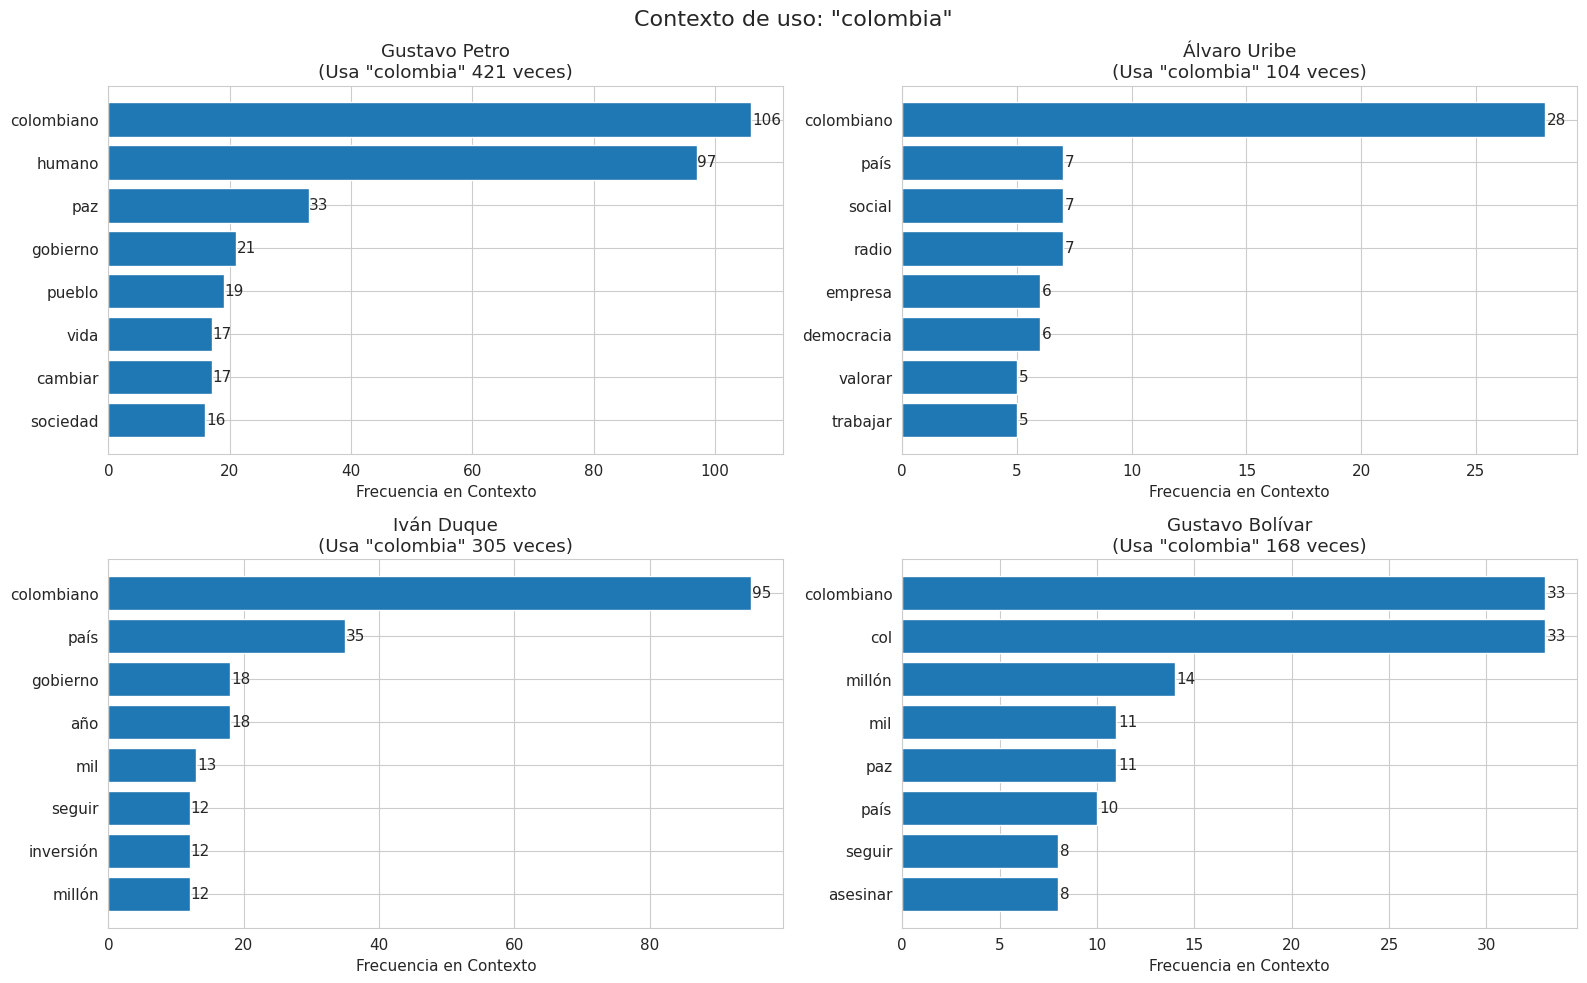

Ejemplos de uso de 'colombia':
  Gustavo Petro: pensado dinero mercantilización bogotá colombia fortalecimiento hospitalario
  Álvaro Uribe: registrado país empresa rico colombia dueño empresa micro pequeño
  Iván Duque: seguir comparecer llamado justicia colombiano principio reparación crimen ocurrir
  Gustavo Bolívar: soscolombiaddhh tendencia mundial llegarer tuit


Analizando contexto de: 'gobierno'


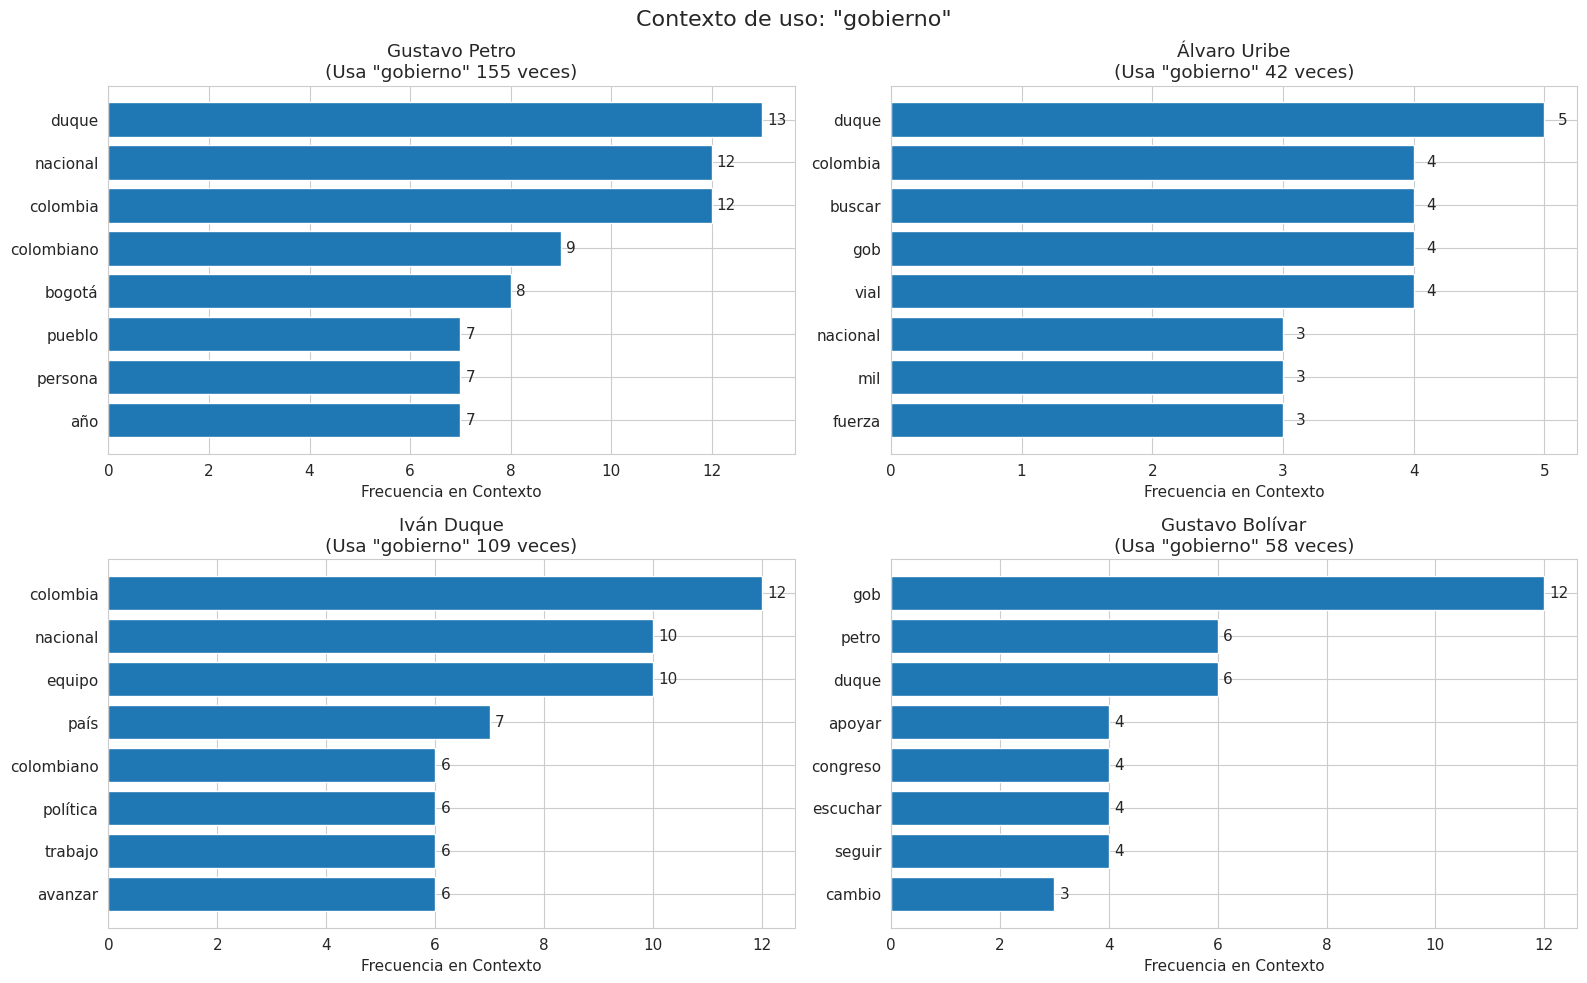

Ejemplos de uso de 'gobierno':
  Gustavo Petro: confinamiento prolongar mes disciplina gobierno ayuda social insuficiente pensado
  Álvaro Uribe: traumático refinanciar deuda gobierno colombia canje deuda año
  Iván Duque: país llevar progreso esconhecho gobierno inversión público región lasregionesproponir
  Gustavo Bolívar: prensa cambio pauta apoyar gobierno uribista


Analizando contexto de: 'pueblo'


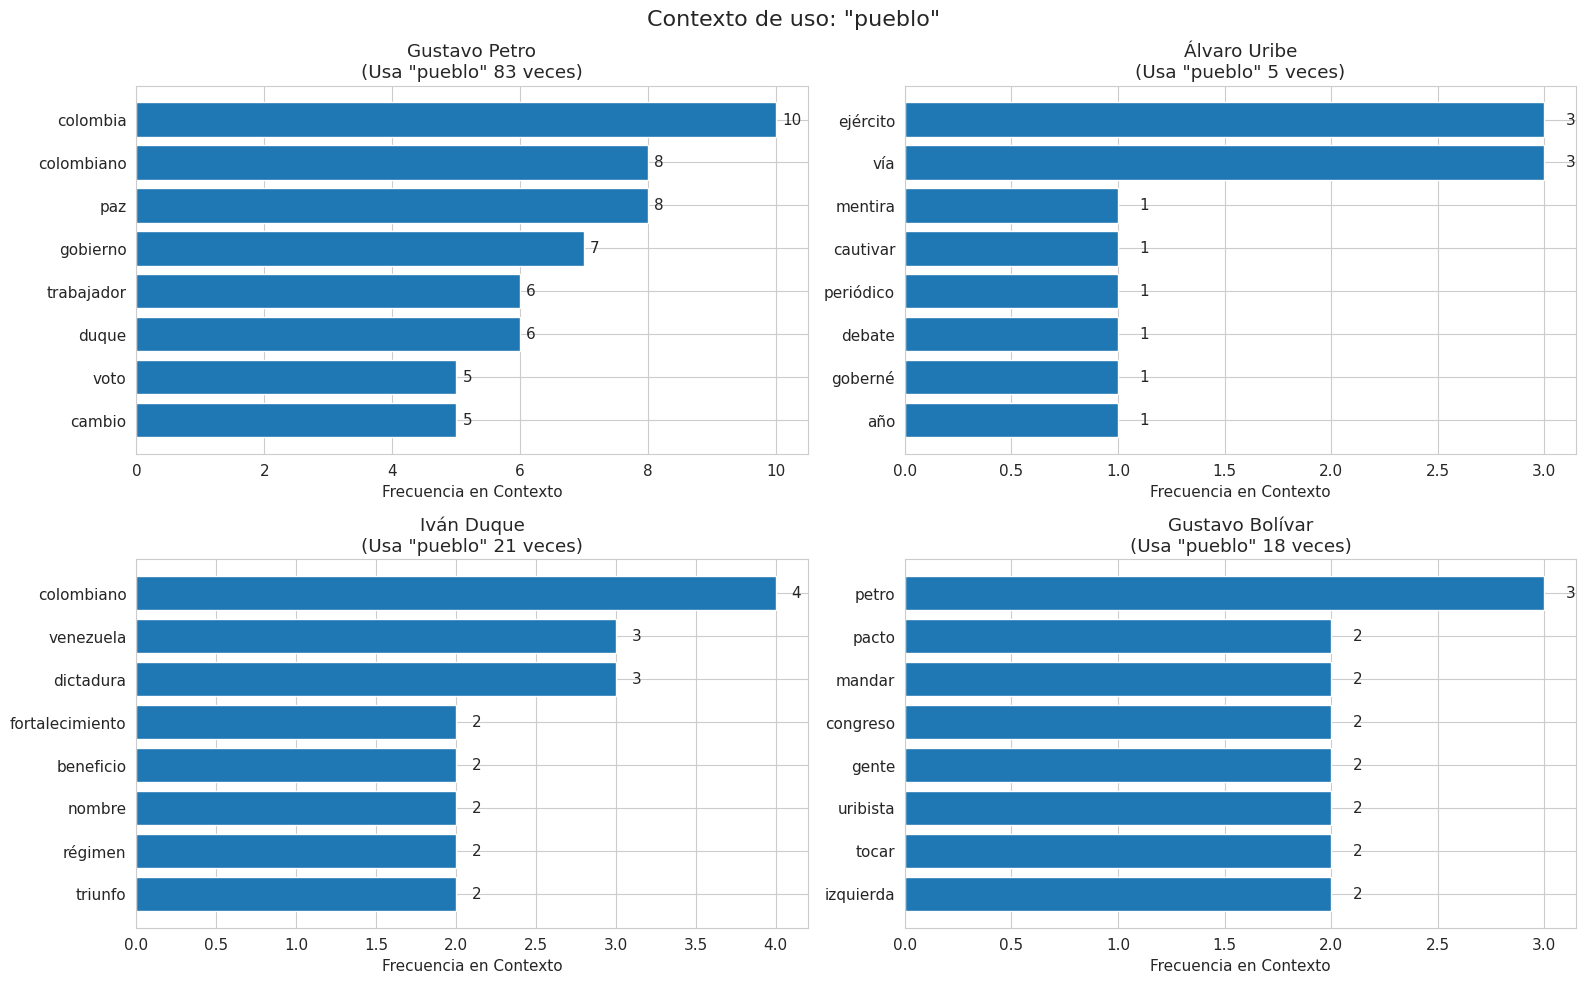

Ejemplos de uso de 'pueblo':
  Gustavo Petro: pueblo perder memoria memoria edificación
  Álvaro Uribe: ejército pueblo pueblo pueblo vía
  Iván Duque: contrato entidad clave fortalecimiento pueblo ancestral promesa cumplir
  Gustavo Bolívar: nasa hacer retumbar voz pueblo senado cámara fijar lunar



In [45]:
# Realizar análisis de contexto
print("Análisis de Contexto de Palabras Clave:")
context_analysis = analyze_context_usage(df, palabras_clave_completas, window_size=4)

# Visualizar contexto para palabras seleccionadas
palabras_principales = ['colombia', 'gobierno', 'pueblo'] + palabras_analisis_detallado

for palabra in palabras_principales:
    if palabra:  # Verificar que la palabra no esté vacía
        print(f"\nAnalizando contexto de: '{palabra}'")
        visualize_context_analysis(context_analysis, palabra)

        # Mostrar ejemplos de contexto
        print(f"Ejemplos de uso de '{palabra}':")
        for politician in context_analysis.keys():
            if palabra in context_analysis[politician]:
                contexts = context_analysis[politician][palabra]['contexts_sample']
                if contexts:
                    print(f"  {politician}: {' '.join(contexts[0])}")
        print()

## 11. Análisis temporal por trimestres

In [46]:
def analyze_temporal_trends(df):
    """
    Analiza tendencias temporales por trimestre
    """
    # Distribución temporal general
    temporal_dist = df.groupby(['año_trimestre', 'politico']).size().unstack(fill_value=0)

    # Análisis de vocabulario por período
    vocab_evolution = {}

    for politician in df['politico'].unique():
        politician_data = df[df['politico'] == politician]
        vocab_evolution[politician] = {}

        for period in politician_data['año_trimestre'].unique():
            period_data = politician_data[politician_data['año_trimestre'] == period]

            # Palabras más frecuentes del período
            period_words = []
            for lemmas in period_data['lemmas']:
                period_words.extend(lemmas)

            word_counts = Counter(period_words).most_common(20)
            vocab_evolution[politician][period] = word_counts

    return temporal_dist, vocab_evolution

def visualize_temporal_analysis(temporal_dist, vocab_evolution):
    """
    Visualiza análisis temporal
    """
    # 1. Evolución temporal general
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Gráfico de líneas temporal
    temporal_dist.plot(kind='line', ax=axes[0], marker='o', linewidth=2)
    axes[0].set_title('Evolución Temporal de Tweets por Trimestre')
    axes[0].set_xlabel('Período')
    axes[0].set_ylabel('Número de Tweets')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Político', bbox_to_anchor=(1.05, 1))
    axes[0].grid(True, alpha=0.3)

    # Heatmap temporal
    import seaborn as sns
    sns.heatmap(temporal_dist.T, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1])
    axes[1].set_title('Heatmap: Actividad por Político y Trimestre')
    axes[1].set_xlabel('Período')
    axes[1].set_ylabel('Político')

    plt.tight_layout()
    plt.show()

    # 2. Análisis de picos de actividad
    print("Análisis de Picos de Actividad:")
    print("="*40)

    for politician in temporal_dist.columns:
        politician_series = temporal_dist[politician]
        max_period = politician_series.idxmax()
        max_tweets = politician_series.max()

        print(f"{politician}:")
        print(f"  - Período más activo: {max_period} ({max_tweets} tweets)")

        # Calcular variación
        variation = politician_series.std() / politician_series.mean() if politician_series.mean() > 0 else 0
        print(f"  - Variabilidad temporal: {variation:.2f}")

def analyze_vocabulary_changes(vocab_evolution, politician, periods_to_compare):
    """
    Analiza cambios en vocabulario entre períodos específicos
    """
    if len(periods_to_compare) < 2:
        print("Se necesitan al menos 2 períodos para comparar")
        return

    period1, period2 = periods_to_compare[0], periods_to_compare[1]

    if (politician not in vocab_evolution or
        period1 not in vocab_evolution[politician] or
        period2 not in vocab_evolution[politician]):
        print(f"Datos insuficientes para {politician} en los períodos especificados")
        return

    # Obtener vocabulario de cada período
    vocab1 = dict(vocab_evolution[politician][period1])
    vocab2 = dict(vocab_evolution[politician][period2])

    # Encontrar palabras nuevas, que desaparecieron, y que cambiaron frecuencia
    words1 = set(vocab1.keys())
    words2 = set(vocab2.keys())

    nuevas_palabras = words2 - words1
    palabras_desaparecidas = words1 - words2
    palabras_comunes = words1 & words2

    print(f"\nAnálisis de cambio vocabulario - {politician}:")
    print(f"Comparando {period1} vs {period2}")
    print(f"- Palabras nuevas en {period2}: {len(nuevas_palabras)}")
    if nuevas_palabras:
        print(f"  Ejemplos: {list(nuevas_palabras)[:5]}")

    print(f"- Palabras que desaparecieron: {len(palabras_desaparecidas)}")
    if palabras_desaparecidas:
        print(f"  Ejemplos: {list(palabras_desaparecidas)[:5]}")

    # Palabras que más aumentaron/disminuyeron en frecuencia
    cambios_frecuencia = []
    for word in palabras_comunes:
        cambio = vocab2[word] - vocab1[word]
        cambios_frecuencia.append((word, cambio, vocab1[word], vocab2[word]))

    # Ordenar por cambio absoluto
    cambios_frecuencia.sort(key=lambda x: abs(x[1]), reverse=True)

    print("- Mayores cambios en frecuencia:")
    for word, change, freq1, freq2 in cambios_frecuencia[:5]:
        if change > 0:
            print(f"  {word}: {freq1} → {freq2} (+{change})")
        else:
            print(f"  {word}: {freq1} → {freq2} ({change})")


Análisis Temporal por Trimestres:


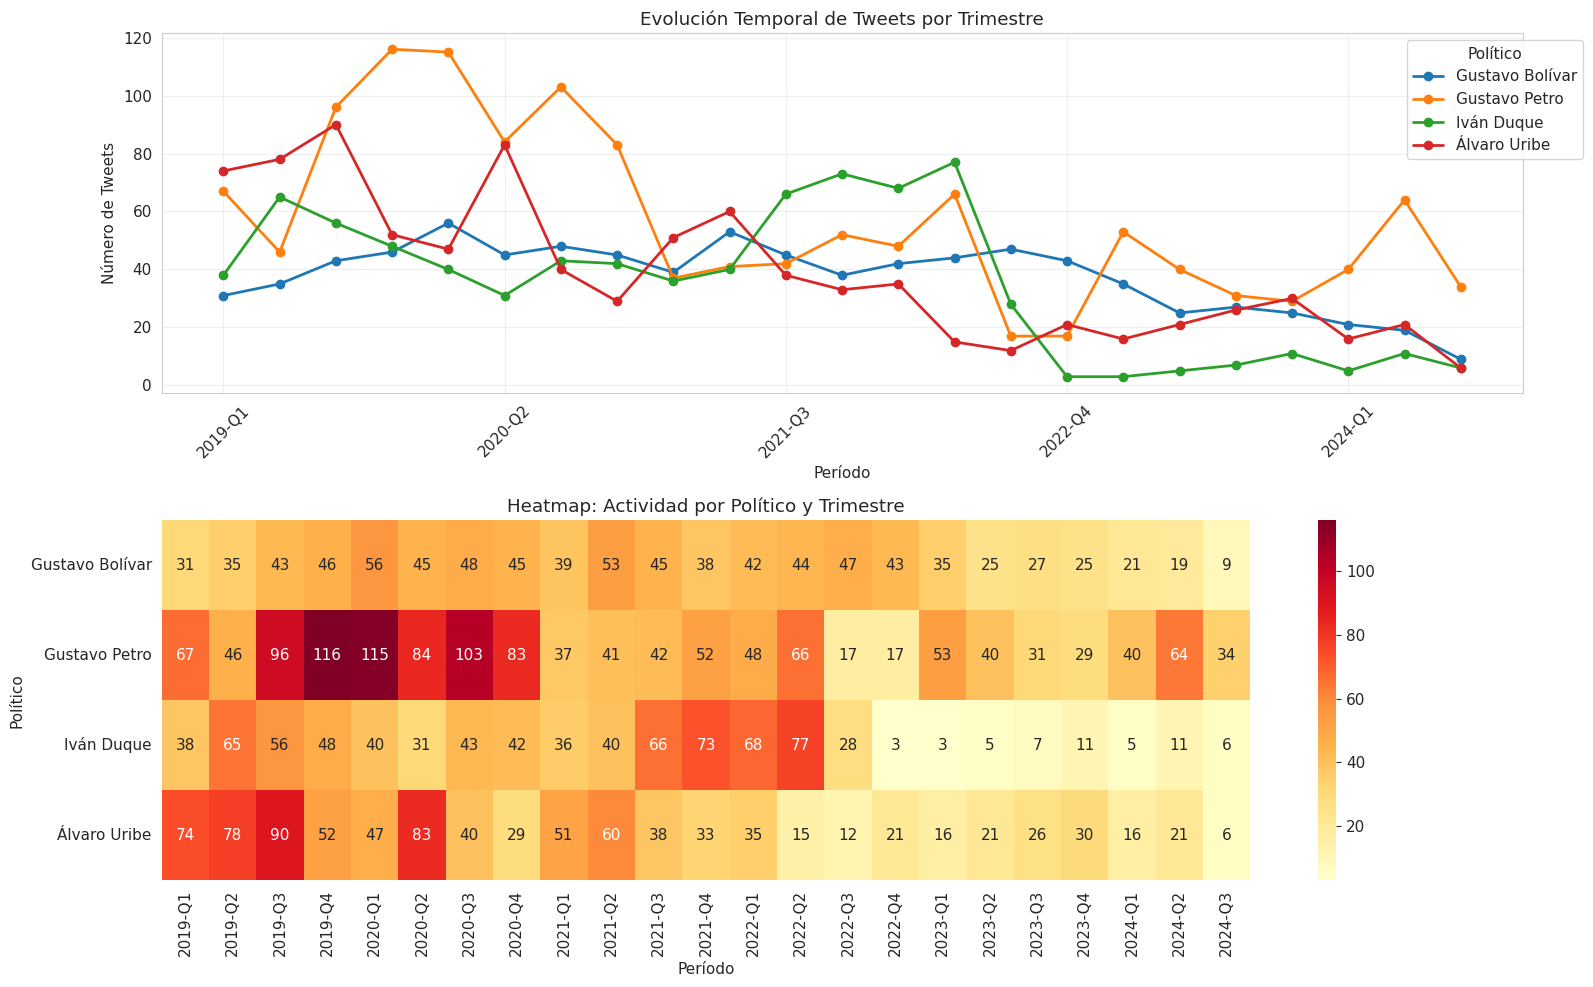

Análisis de Picos de Actividad:
Gustavo Bolívar:
  - Período más activo: 2020-Q1 (56 tweets)
  - Variabilidad temporal: 0.31
Gustavo Petro:
  - Período más activo: 2019-Q4 (116 tweets)
  - Variabilidad temporal: 0.51
Iván Duque:
  - Período más activo: 2022-Q2 (77 tweets)
  - Variabilidad temporal: 0.71
Álvaro Uribe:
  - Período más activo: 2019-Q3 (90 tweets)
  - Variabilidad temporal: 0.62

Períodos disponibles para análisis:
['2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1', '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1', '2024-Q2', '2024-Q3']


In [47]:
# Realizar análisis temporal
print("Análisis Temporal por Trimestres:")
temporal_distribution, vocabulary_evolution = analyze_temporal_trends(df)
visualize_temporal_analysis(temporal_distribution, vocabulary_evolution)

# Mostrar períodos disponibles
print("\nPeríodos disponibles para análisis:")
all_periods = sorted(df['año_trimestre'].unique())
print(all_periods)